# Basics

In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

RSEED=33

c = ['#599190', '#EDAFB8', '#666A86', '#95B8D1', '#E8DDB5']
color_cfm = ['#EAF2F2', '#D9E8E8', '#CCDFDF', '#BCD6D5', "#AACBCA", '#9AC1C1', '#83B3B2', '#77ABAA', '#6BA4A3', '#5F9C9A', '#599190']

In [2]:
# load data

original_train = pd.read_csv('data/Train.csv')
original_test = pd.read_csv('data/Test.csv')
variables = pd.read_csv('data/VariableDefinitions.csv')

## Clustering

I'll try to find some clusters of "typical" bank account holders with a clustering algorithm now. I'll use Kmodes since it can handle categorical data too. 

In [3]:
#preprocess data for unsupervised learning (clustering), bank_account holders only

from sklearn import preprocessing

bank_customers = original_train.loc[(original_train.bank_account == "Yes")]
bank_customers_scaled = bank_customers.drop(['country', 'year', 'uniqueid'], axis=1)
scaler = preprocessing.MinMaxScaler()
bank_customers_scaled[['age','household']] = scaler.fit_transform(bank_customers[['age_of_respondent','household_size']])

In [4]:
# remove bank account status to obtain clusters not influenced by this (all in the data frame have bank accounts anyways)

bank_customers_scaled2 = bank_customers_scaled.drop(['bank_account'], axis=1)

In [5]:
# import the necessary package

from kmodes.kprototypes import KPrototypes

In [6]:
# in order to find the perfect number of clusters, I'll use the elbow method
# since this step here takes too long when restarting the kernel I just run it once

# cost = []
# K = range(1,6)
# for num_clusters in list(K):
#     kproto = KPrototypes (n_clusters=num_clusters, init = "Cao", n_init = 5, verbose=1)
#     kproto.fit_predict(bank_customers, categorical=[0,1,4,5,6,7,8])
#     cost.append(kproto.cost_)

In [7]:
# I save the cost computed in the previous step in a variable

K = range(1,6)
cost = [861.9096379127745,
 706.6471529581682,
 626.3374351760665,
 581.6180868797991,
 556.8295447906916]

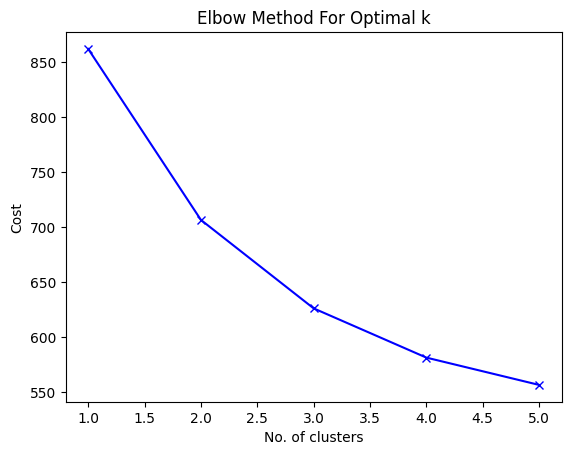

In [8]:
# I plot the cost agains number of clusters
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [9]:
# optimal k is 4
# now I run the clustering
# clusters are stored in variable "clusters"

kproto = KPrototypes(n_clusters=4, init='Cao')
clusters = kproto.fit_predict(bank_customers_scaled2, categorical=[0,1,4,5,6,7,8])

In [10]:
# reset index
bank_customers.reset_index(drop=True, inplace=True)

In [11]:
# convert clusters to series
df_cluster = pd.Series(clusters, name='Cluster')

# concatenate clusters and bank_customers to obtain a dataframe with the original data and a new column "clusters"
df_clustered = pd.concat([bank_customers, df_cluster], axis=1)

In [12]:
# map segments to clusters
df_clustered['Segment'] = df_clustered['Cluster'].map({0:'First', 1:'Second', 2:'Third', 3: 'Fourth'})

# save segments as categorical data
df_clustered['Segment'] = df_clustered['Segment'].astype('category')

# group by segment and aggregate data (mean for numerical, mode for categorical)
df_clustered.groupby('Segment').agg(
    {'Cluster':'count',
    'location_type': lambda x: x.value_counts().index[0],
    'cellphone_access': lambda x: x.value_counts().index[0],
    'household_size': 'mean',
    'age_of_respondent': 'mean',
    'gender_of_respondent': lambda x: x.value_counts().index[0],
    'relationship_with_head': lambda x: x.value_counts().index[0],
    'marital_status': lambda x: x.value_counts().index[0],
    'education_level': lambda x: x.value_counts().index[0],
    'job_type': lambda x: x.value_counts().index[0],
    }
).reset_index()

,Segment,Cluster,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,First,304,Rural,Yes,3.115132,70.891447,Male,Head of Household,Married/Living together,Primary education,Farming and Fishing
1,Fourth,630,Rural,Yes,3.868254,52.604762,Male,Head of Household,Married/Living together,Primary education,Farming and Fishing
2,Second,1105,Rural,Yes,4.149321,38.500452,Male,Head of Household,Married/Living together,Primary education,Self employed
3,Third,1273,Urban,Yes,3.214454,26.641005,Female,Head of Household,Single/Never Married,Secondary education,Self employed
